In [25]:
# Importing the Keras libraries and packages
# 사용할 패키지 불러오기
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [26]:
# Initialising the CNN`
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))


# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
#classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(Conv2D(20, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))


classifier.add(Conv2D(90, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))


# Step 3 - Flattening
classifier.add(Flatten())


# Step 4 - Full connection
#classifier.add(Dense(units = 128, activation = 'relu'))
#classifier.add(Dense(units = 1, activation = 'sigmoid'))

classifier.add(Dense(activation='relu', units=64))
classifier.add(Dense(activation='softmax', units=4))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compiling the CNN
#classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#loss : 현재 가중치 세트를 평가하는 데 사용한 손실 함수 입니다. 다중 클래스 문제이므로 ‘categorical_crossentropy’으로 지정합니다.
#optimizer : 최적의 가중치를 검색하는 데 사용되는 최적화 알고리즘으로 효율적인 경사 하강법 알고리즘 중 하나인 ‘adam’을 사용합니다.
#metrics : 평가 척도를 나타내며 분류 문제에서는 일반적으로 ‘accuracy’으로 지정합니다.
classifier.compile(loss='sparse_categorical_crossentropy',
                 optimizer='sgd',
                  metrics=['accuracy'])

# adam -> sgd

In [27]:
# 데이터셋 생성하기

# ImageDataGenerator : 이미지 전처리. 실시간 데이터 증강을 사용해서 텐서 이미지 데이터 배치를 생성합니다. 데이터에 대해 (배치 단위로) 루프가 순환됩니다.

# rescale : 크기 재조절 인수. 디폴트 값은 None입니다. None 혹은 0인 경우 크기 재조절이 적용되지 않고, 그 외의 경우 (다른 변형을 전부 적용한 후에) 데이터를 주어진 값으로 곱합니다.
# shear_range : 부동소수점. 층밀리기의 강도입니다. (도 단위의 반시계 방향 층밀리기 각도)
# zoom_range : 부동소수점 혹은 [하한, 상산]. 무작위 줌의 범위입니다. 부동소수점인 경우, [하한, 상한] = [1-zoom_range, 1+zoom_range]입니다.
# horizontal_flip : 불리언. 인풋을 무작위로 가로로 뒤집습니다.

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 24,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 24,
                                            class_mode = 'binary')


Found 2572 images belonging to 3 classes.
Found 400 images belonging to 3 classes.


In [28]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#%matplotlib inline

#SVG(model_to_dot(classifier, show_shapes=True).create(prog='dot', format='svg'))

In [29]:
# 추가
import os
MODEL_DIR = './model'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"

checkpointer = ModelCheckpoint(filepath = modelpath, monitor='val_loss', verbose=1, save_best_only=True)

In [30]:
checkpoint_path = "./training_face_shape/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

#10회 간 Validation점수가 좋아지지 않으면 중지합니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

classifier.save_weights(checkpoint_path.format(epoch=0))

his = classifier.fit_generator(training_set,
                               steps_per_epoch = 20,
                               epochs = 500,
                               validation_data = test_set,
                               validation_steps=20,
                               callbacks=[checkpointer, early_stopping])

#his = classifier.fit_generator(training_set,
#                         steps_per_epoch = 347,
#                         verbose=1,
#                         epochs = 50,
#                         validation_data = test_set,
#                         validation_steps=11, callbacks=[checkpointer])

Epoch 1/500
20/20 [==============================] - 12s 597ms/step - loss: 1.2159 - accuracy: 0.4375 - val_loss: 0.9200 - val_accuracy: 0.6081

Epoch 00001: val_loss improved from inf to 0.92003, saving model to ./model/01-0.9200.hdf5
Epoch 2/500
20/20 [==============================] - 10s 481ms/step - loss: 1.0184 - accuracy: 0.4708 - val_loss: 0.8474 - val_accuracy: 0.5657

Epoch 00002: val_loss improved from 0.92003 to 0.84738, saving model to ./model/02-0.8474.hdf5
Epoch 3/500
20/20 [==============================] - 9s 470ms/step - loss: 1.0133 - accuracy: 0.4826 - val_loss: 0.9828 - val_accuracy: 0.4767

Epoch 00003: val_loss did not improve from 0.84738
Epoch 4/500
20/20 [==============================] - 10s 484ms/step - loss: 1.0323 - accuracy: 0.4708 - val_loss: 0.9700 - val_accuracy: 0.2754

Epoch 00004: val_loss did not improve from 0.84738
Epoch 5/500
20/20 [==============================] - 11s 570ms/step - loss: 0.9833 - accuracy: 0.4958 - val_loss: 1.0399 - val_accura

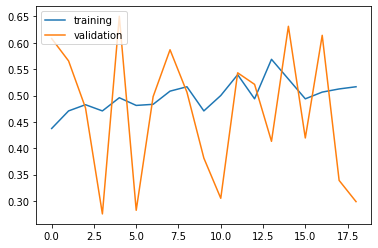

In [31]:
import matplotlib.pyplot as plt

plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [32]:
ls {checkpoint_dir}

매개 변수 포맷이 틀립니다 - "raining_face_shape".


In [33]:
#classifier.save('./my_face_shape_model2.h5')
classifier.save('models/my_model_12')
#del classifier
#classifier = load_model('my_model.h5')

In [34]:
from keras.models import load_model
classifier = load_model('models/my_model_12')

classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 20)        5780      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 90)        16290     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 90)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3240)             

In [35]:
print("-- Evaluate --")
scores = classifier.evaluate_generator(test_set, steps=5)

#print(his.history['loss'])
#print(his.history['acc'])
#print(his.history['val_loss'])
#print(his.history['val_acc'])

#classifier.save("face_shape_model.h5")
print("%s: %.2f%%" %(classifier.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 32.50%


In [36]:
print("\n Test Accuracy: %.4f" % (classifier.evaluate(test_set)[1]))
print("\n Test Accuracy: %.4f" % (classifier.evaluate(test_set)[0]))

17/17 [==============================] - 8s 486ms/step

 Test Accuracy: 0.3000
17/17 [==============================] - 7s 428ms/step

 Test Accuracy: 1.2097


In [15]:
import numpy as np
from keras.preprocessing import image

In [16]:
test_image = image.load_img('../virtual_makeup/test_image/ex2.jpg', target_size = (64, 64))
#test_image = image.img_to_array(test_image)
#test_image = np.expand_dims(test_image, axis = 0)
#output = classifier.predict_generator(test_image, steps=5)
#output
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

In [17]:
result = classifier.predict(test_image)

In [18]:
result

array([[9.9997401e-01, 2.5984327e-05, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)

In [19]:
np.around(result)
result=result.argmax()

In [20]:
result


0

In [21]:
training_set.class_indices

{'Oblong': 0, 'Round': 1, 'Square': 2}

In [22]:
if result == 0:
    prediction = 'Oblong'
elif result == 1:
    prediction = 'Round'
else:
    prediction = 'Square'

In [23]:
prediction

'Oblong'

In [21]:
from tensorflow.compat.v2.keras.models import model_from_json 

# model.json 파일 열기 
json_file = open("CNN_fashion_mnist_model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 

# json파일로부터 model 로드하기 
loaded_model = model_from_json(loaded_model_json) 
# 로드한 model에 weight 로드하기 
loaded_model.load_weights("CNN_fashion_mnist_model.h5") 
print("Loaded model from disk")


FileNotFoundError: [Errno 2] No such file or directory: 'CNN_fashion_mnist_model.json'

In [22]:
# 모델 컴파일 
loaded_model.compile(optimizer = 'adam', 
                     loss = 'sparse_categorical_crossentropy', 
                     metrics = ['accuracy']) 

# 모델 evaluation 
test_loss, test_acc = loaded_model.evaluate(test_X, test_y) 
print("Accuracy : %.2f%%" % (test_acc*100))


NameError: name 'loaded_model' is not defined